# supernode-features

The procedure of collecting and engineering supernode features for subsequent clustering.

Requires:

1. `data/supernodes/supernode_attributes.json`
2. `data/supernodes/edges_lspace.json`
3. `data/supernodes/edges_pspace.json`

Produces:
1. `data/features/infrastructure_features.json`

In [1]:
import sys
sys.path.append('..')

In [118]:
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

from myutils.json import load_json, save_json

from config import supernode_attributes_fpath, edges_lspace_fpath, edges_pspace_fpath, \
    infrastructure_features_fpath, lspace_features_fpath

In [3]:
supernode_attributes = pd.read_json(supernode_attributes_fpath).set_index('id')

supernode_attributes.head(2)

,residential_building,shop,catering_place,service,medicine,sight_place_tourism,education,company,sport,car_supply,organisation,supermarket,hotel_business,electronics_and_telecommunication,bank_and_money,printing_and_books,religion,post_office,business_center_or_mall_or_marketplace
id,,,,,,,,,,,,,,,,,,,
0,39,9,3,2,4,4,6,2,3,0,2,3,0,0,1,0,0,1,0
1,5,172,48,35,10,3,3,11,2,6,2,2,0,9,3,13,3,7,7


In [122]:
edges_lspace = [tuple(item.values()) for item in load_json(edges_lspace_fpath)]

edges_lspace[:5]

[(626, 836, 6), (836, 837, 10), (17, 837, 10), (17, 309, 12), (75, 309, 12)]

In [123]:
edges_pspace = [tuple(item.values()) for item in load_json(edges_pspace_fpath)]

edges_pspace[:5]

[(626, 836, 0.44657616594606997),
 (626, 837, 0.9102138231959868),
 (17, 626, 1.1097232146063742),
 (309, 626, 1.5763256068546179),
 (75, 626, 1.9253778263958403)]

## Infrastructure features

In [8]:
infrastructure_features = supernode_attributes.copy()

total = infrastructure_features.sum(axis=1)
infrastructure_features = infrastructure_features.divide(total, axis=0)
infrastructure_features['total'] = total

infrastructure_features.head(2)

,residential_building,shop,catering_place,service,medicine,sight_place_tourism,education,company,sport,car_supply,organisation,supermarket,hotel_business,electronics_and_telecommunication,bank_and_money,printing_and_books,religion,post_office,business_center_or_mall_or_marketplace,total
id,,,,,,,,,,,,,,,,,,,,
0,0.493671,0.113924,0.037975,0.025316,0.050633,0.050633,0.075949,0.025316,0.037975,0.000000,0.025316,0.037975,0.0,0.000000,0.012658,0.000000,0.000000,0.012658,0.000000,79
1,0.014663,0.504399,0.140762,0.102639,0.029326,0.008798,0.008798,0.032258,0.005865,0.017595,0.005865,0.005865,0.0,0.026393,0.008798,0.038123,0.008798,0.020528,0.020528,341


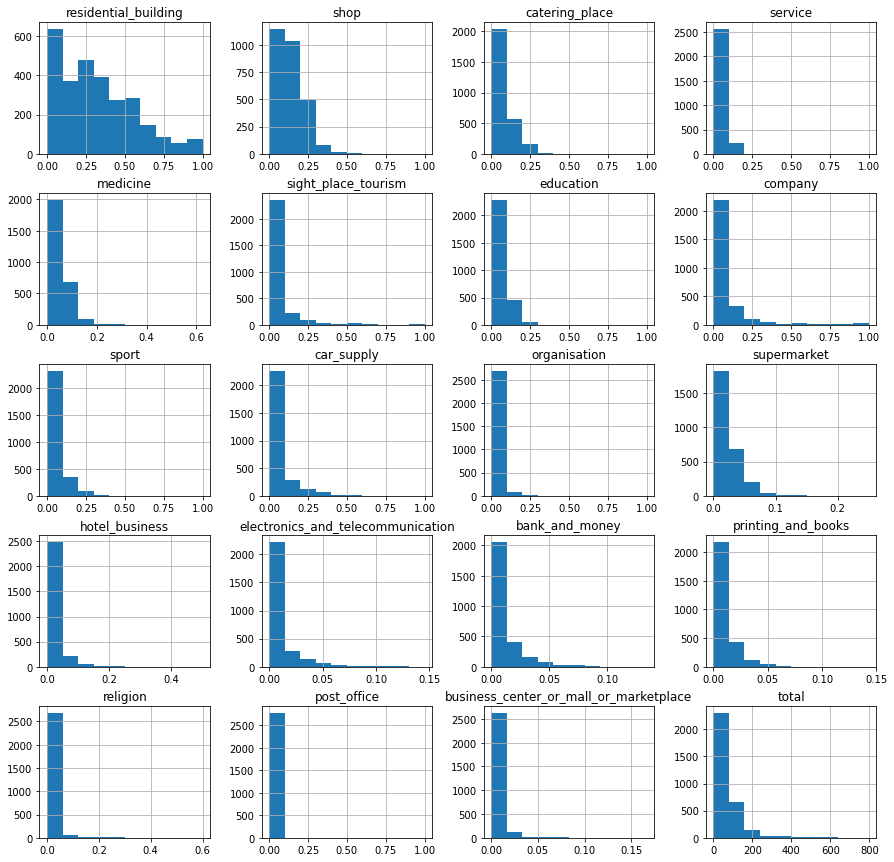

In [9]:
infrastructure_features.hist(figsize=(15, 15));

<AxesSubplot:>

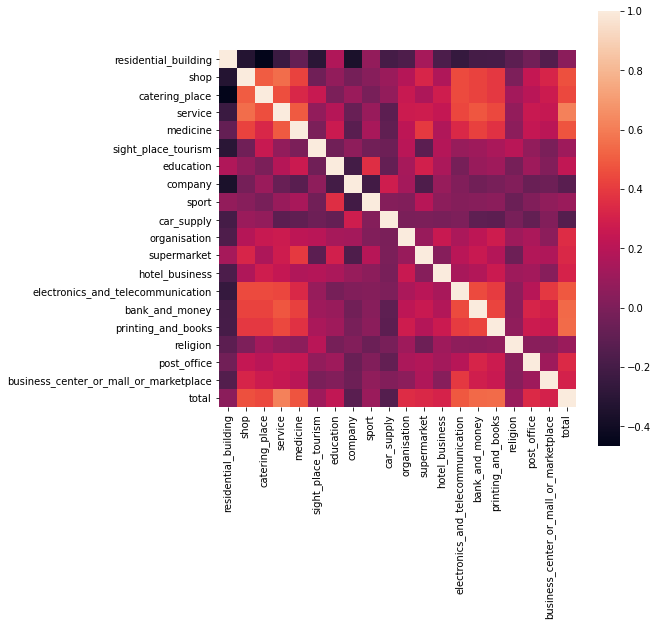

In [107]:
plt.figure(figsize=(8, 8))

sns.heatmap(infrastructure_features.corr(method='spearman'), square=True)

In [15]:
infrastructure_features_json = []

for _, row in infrastructure_features.reset_index().iterrows():
    row = row.to_dict()
    row['id'] = int(row['id'])
    infrastructure_features_json.append(row)

In [17]:
save_json(infrastructure_features_json, infrastructure_features_fpath)

## L-space features

In [124]:
lspace = nx.Graph()
lspace.add_weighted_edges_from(edges_lspace)

nx.set_edge_attributes(
    lspace,
    values=(1 / pd.Series(nx.get_edge_attributes(lspace, 'weight'))).to_dict(),
    name='distance',
)

len(lspace), len(lspace.edges)

(3226, 5352)

In [73]:
neighbours = {node: set(lspace.neighbors(node)) for node in lspace.nodes}
neighbours_2hop = {node: set.union(*[neighbours[n] for n in neighbours[node]]) for node in lspace.nodes}

In [52]:
degree = pd.Series(
    nx.adjacency_matrix(lspace).sum(axis=0).A.flatten() / len(lspace),
    index=lspace.nodes,
)

degree.head(2)

626    0.00744
836    0.00620
dtype: float64

In [75]:
degree_1hop_mean = pd.Series({
    node: degree.loc[neighbours[node]].mean()
    for node in lspace.nodes
})

degree_1hop_mean.head(2)

626    0.016842
836    0.008473
dtype: float64

In [78]:
degree_2hop_mean = pd.Series({
    node: degree.loc[neighbours_2hop[node]].mean()
    for node in lspace.nodes
})

degree_2hop_mean.head(2)

626    0.011917
836    0.013577
dtype: float64

In [81]:
clustering = pd.Series(nx.clustering(lspace))

clustering.head(2)

626    0.666667
836    0.333333
dtype: float64

In [83]:
clustering_1hop_mean = pd.Series({
    node: clustering.loc[neighbours[node]].mean()
    for node in lspace.nodes
})

clustering_1hop_mean.head(2)

626    0.358730
836    0.444444
dtype: float64

In [86]:
clustering_2hop_mean = pd.Series({
    node: clustering.loc[neighbours_2hop[node]].mean()
    for node in lspace.nodes
})

clustering_2hop_mean.head(2)

626    0.192269
836    0.348571
dtype: float64

In [49]:
betweenness_centrality = pd.Series(nx.betweenness_centrality(lspace, weight='distance'))

betweenness_centrality.head(2)

626    3.986093e-04
836    5.770673e-07
dtype: float64

In [90]:
betw_centr_1hop_mean = pd.Series({
    node: betweenness_centrality.loc[neighbours[node]].mean()
    for node in lspace.nodes
})

betw_centr_1hop_mean.head(2)

626    0.093540
836    0.000544
dtype: float64

In [93]:
betw_centr_2hop_mean = pd.Series({
    node: betweenness_centrality.loc[neighbours_2hop[node]].mean()
    for node in lspace.nodes
})

betw_centr_2hop_mean.head(2)

626    0.054850
836    0.056413
dtype: float64

In [95]:
lspace_features = pd.DataFrame({
    'degree': degree,
    'degree_1hop_mean': degree_1hop_mean,
    'degree_2hop_mean': degree_2hop_mean,
    'clustering': clustering,
    'clustering_1hop_mean': clustering_1hop_mean,
    'clustering_2hop_mean': clustering_2hop_mean,
    'betweenness_centrality': betweenness_centrality,
    'betw_centr_1hop_mean': betw_centr_1hop_mean,
    'betw_centr_2hop_mean': betw_centr_2hop_mean,
})

lspace_features.head(2)

,degree,degree_1hop_mean,degree_2hop_mean,clustering,clustering_1hop_mean,clustering_2hop_mean,betweenness_centrality,betw_centr_1hop_mean,betw_centr_2hop_mean
626,0.00744,0.016842,0.011917,0.666667,0.358730,0.192269,3.986093e-04,0.093540,0.054850
836,0.00620,0.008473,0.013577,0.333333,0.444444,0.348571,5.770673e-07,0.000544,0.056413


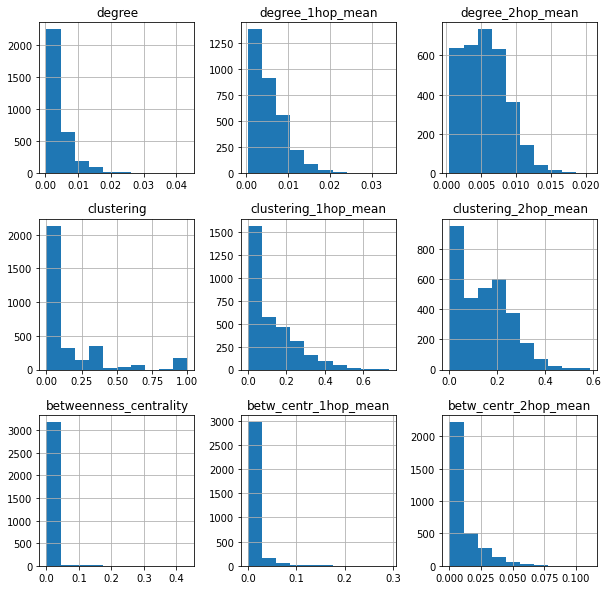

In [111]:
lspace_features.hist(figsize=(10, 10));

<AxesSubplot:>

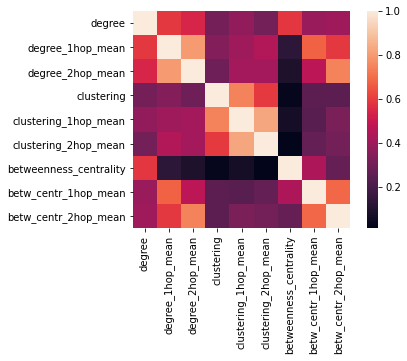

In [109]:
sns.heatmap(lspace_features.corr(method='spearman'), square=True)

In [101]:
lspace_features_json = []

for i, row in lspace_features.sort_index().iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    lspace_features_json.append(item)
    
lspace_features_json[0]

{'id': 0,
 'degree': 0.017978921264724116,
 'degree_1hop_mean': 0.00884855999549118,
 'degree_2hop_mean': 0.0091692498450093,
 'clustering': 0.12727272727272726,
 'clustering_1hop_mean': 0.2963570026811133,
 'clustering_2hop_mean': 0.16404714334139558,
 'betweenness_centrality': 0.008443072306538173,
 'betw_centr_1hop_mean': 0.004128623939201584,
 'betw_centr_2hop_mean': 0.019366442636300104}

In [102]:
save_json(lspace_features_json, lspace_features_fpath)

## P-space features

In [125]:
pspace = nx.Graph()
pspace.add_weighted_edges_from(edges_pspace, weight='distance')

len(pspace), len(pspace.edges)

(3226, 120039)

In [129]:
neighbours = {node: set(pspace.neighbors(node)) for node in pspace.nodes}
neighbours_2hop = {node: set.union(*[neighbours[n] for n in neighbours[node]]) for node in lspace.nodes}

In [130]:
degree = pd.Series(dict(pspace.degree)) / len(pspace)

degree.head(2)

626    0.064166
836    0.025108
dtype: float64

In [131]:
degree_1hop_mean = pd.Series({
    node: degree.loc[neighbours[node]].mean()
    for node in pspace.nodes
})

degree_1hop_mean.head(2)

626    0.036184
836    0.037301
dtype: float64

In [132]:
degree_2hop_mean = pd.Series({
    node: degree.loc[neighbours_2hop[node]].mean()
    for node in pspace.nodes
})

degree_2hop_mean.head(2)

626    0.029604
836    0.033316
dtype: float64

In [133]:
clustering = pd.Series(nx.clustering(pspace))

clustering.head(2)

626    0.240842
836    0.652160
dtype: float64

In [134]:
clustering_1hop_mean = pd.Series({
    node: clustering.loc[neighbours[node]].mean()
    for node in pspace.nodes
})

clustering_1hop_mean.head(2)

626    0.537564
836    0.547466
dtype: float64

In [135]:
clustering_2hop_mean = pd.Series({
    node: clustering.loc[neighbours_2hop[node]].mean()
    for node in pspace.nodes
})

clustering_2hop_mean.head(2)

626    0.595903
836    0.557089
dtype: float64

In [ ]:
betweenness_centrality = pd.Series(nx.betweenness_centrality(pspace, weight='distance'))

betweenness_centrality.head(2)

In [90]:
betw_centr_1hop_mean = pd.Series({
    node: betweenness_centrality.loc[neighbours[node]].mean()
    for node in pspace.nodes
})

betw_centr_1hop_mean.head(2)

626    0.093540
836    0.000544
dtype: float64

In [93]:
betw_centr_2hop_mean = pd.Series({
    node: betweenness_centrality.loc[neighbours_2hop[node]].mean()
    for node in pspace.nodes
})

betw_centr_2hop_mean.head(2)

626    0.054850
836    0.056413
dtype: float64

In [95]:
pspace_features = pd.DataFrame({
    'degree': degree,
    'degree_1hop_mean': degree_1hop_mean,
    'degree_2hop_mean': degree_2hop_mean,
    'clustering': clustering,
    'clustering_1hop_mean': clustering_1hop_mean,
    'clustering_2hop_mean': clustering_2hop_mean,
    'betweenness_centrality': betweenness_centrality,
    'betw_centr_1hop_mean': betw_centr_1hop_mean,
    'betw_centr_2hop_mean': betw_centr_2hop_mean,
})

pspace_features.head(2)

,degree,degree_1hop_mean,degree_2hop_mean,clustering,clustering_1hop_mean,clustering_2hop_mean,betweenness_centrality,betw_centr_1hop_mean,betw_centr_2hop_mean
626,0.00744,0.016842,0.011917,0.666667,0.358730,0.192269,3.986093e-04,0.093540,0.054850
836,0.00620,0.008473,0.013577,0.333333,0.444444,0.348571,5.770673e-07,0.000544,0.056413


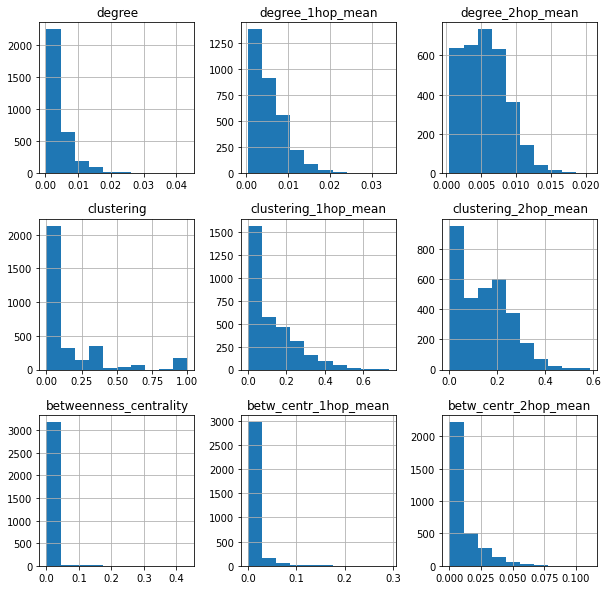

In [111]:
pspace_features.hist(figsize=(10, 10));

<AxesSubplot:>

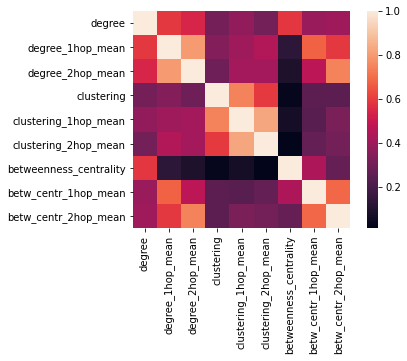

In [109]:
sns.heatmap(pspace_features.corr(method='spearman'), square=True)

In [101]:
pspace_features_json = []

for i, row in pspace_features.sort_index().iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    pspace_features_json.append(item)
    
pspace_features_json[0]

{'id': 0,
 'degree': 0.017978921264724116,
 'degree_1hop_mean': 0.00884855999549118,
 'degree_2hop_mean': 0.0091692498450093,
 'clustering': 0.12727272727272726,
 'clustering_1hop_mean': 0.2963570026811133,
 'clustering_2hop_mean': 0.16404714334139558,
 'betweenness_centrality': 0.008443072306538173,
 'betw_centr_1hop_mean': 0.004128623939201584,
 'betw_centr_2hop_mean': 0.019366442636300104}

In [102]:
save_json(pspace_features_json, pspace_features_fpath)